# Redes Neuronales
## Trabajo Práctico N° 1 - Ejercicio 2
* Kammann, Lucas Agustín
* Gaytan, Joaquín Oscar

### Consultas y/o dudas
* Validación de variables biológicas 
* Estimar probabilidades de un valor determinado en VAC => usar PDF (es proporcional)
* Criterio para identificar outliers ("leve"?) => usando distancia a cuartiles > 1.5 * IQR

### To do
* Manejo de NaN
* Variables a tomar en cuenta
* Outliers
* Explicaciones
* Cuentitas haciendo cosas
* Laplacian smoothing

### Step by step
* Importar dataset
* Filtrar dataset (Valores inválidos)
* Análisis estadístico
    * Resumen de parámetros estadísticos
    * Boxplot
    * Filtrado de outliers
    * Histogramas
* Entrenamiento del modelo
* Elección de métrica (recall) y validación del modelo
    * Optimización de hiperparámetros? (Cuáles?)
* Test del modelo y resultados finales
* Comparación con SKLearn


# Descripción del problema
Se busca desarrollar un clasificador para poder predcir la aparición de diabetes en un individuo a partir de algunas de sus características biológicas. Dicha clasificación se realiza a partir del Prima Indians Diabetes Dataset, pereteneciente al National Institute of Diabetes and Digestive and Kidney Diseases. Esta base de datos comprende pacientes femeninos de al menos 21 años de edad, de herencia Prima Indian.

El primer paso es el de importar y filtrar los datos de este dataframe, de forma tal de dejarlos acondicionados para entrenar y validar al modelo. Además, se debe realizar un análisis de cada una de las variables involucradas para ver cuáles de ellas son imprescindibles en el proceso.

### Clasificador

El clasificador a implementar será del tipo Naive Bayes Gaussiano. La principal característica del mismo es asumir que cada una de las variables son independientes entre sí, y que cada una de ellas adopta una distribución del tipo normal. Luego, se divide a la base de datos entre personas con diagnóstico poitivo de diabetes, y aquellas que obtuvieron el resultado contrario. Para cada sub-dataset y para cada variable involucrada se calculan la media y el desvío estándar.

Luego, para clasificar una muestra como diabetes positivo o negativo, se evalúan los parámetros en la PDF gaussiana y se calculan los likelihoods correspondientes. Se multiplica por la probabilidad a priori y se obtiene un valor proporcional a  la probabilidad a posteriori. Se repite para el otro grupo y se hace el cociente de los resultados, resultando en el "odds" del clasificador. En función a su valor se clasifica a una persona como diabética o no.


# Análisis y filtrado de la base de datos

En primer lugar, se importa la base de datos mencionada anteriormente para poder ser procesada. Además se muestran las primeras filas.

In [1]:
import pandas as pd

# Read database from .csv
df = pd.read_csv('../assets/diabetes.csv', delimiter=',')

# Show first rows of data
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Como se observa en la tabla anterior, las variables a considerar para estimar la presencia de diabetes en una persona son las siguientes:

*   Pregnancies (embarazos): Número de embarazos
*   Glucose: Concentración de glucosa en sangre a 2 horas de una prueba de tolerancia de glucosa oral.
*   BloodPresure (Presión sanguinea): Presión diastólica (mm Hg)
*   SkinThickness: Tamaño del pliegue de la piel del triceps
*   Insulin: Insulina en sangre a 2 horas (mu U/ml)
*   BMI: Indice de masa corporal (peso en kg / (altura en metros)^2)
*   DiabetesPedigreeFunction: Una función que estima el likelihood de tener diabetes dado el historial familiar
*   Age: Edad (años)
*   Outcome: Variable 0 o 1 (0 no posee diabtes, 1 posee diabetes)

Antes de comenzar con el análisis estadístico de cada una de estas variables es necesario filtrar aquellos valores que no fueron informados. De lo contrario, estos valores sin sentido afectarán el desempeño del modelo al realizar la predicción.

## Filtrado de datos inválidos

In [2]:
# Show database variables and their characteristics
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
# Describing database
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


De la tabla anterior se aprecia que hay ciertas variables biológicas que adoptan valores inválidos. Por ejemplo, la presión arterial no puede ser nula. Lo mismo sucede con el nivel de glucosa, el grosor de la piel, el nivel de insulina, el ínidice de masa corporal. Luego, se reemplazan aquellos valores sin sentido por un NaN (not a number) para evitar que sean contemplados al realizar el análisis estadístico posterior, preservando los parámetros de las distribuciones.

In [4]:
import numpy as np

# Filtering Glucose values
df['Glucose'].replace(0, np.nan, inplace=True)

# Filtering Blood Pressure values
df['BloodPressure'].replace(0, np.nan, inplace=True)

# Filtering Skin Thickness values
df['SkinThickness'].replace(0, np.nan, inplace=True)

# Filtering Insulin values
df['Insulin'].replace(0, np.nan, inplace=True)

# Filtering Body Mass Index values
df['BMI'].replace(0, np.nan, inplace=True)

# Describing filtered dataset characterisics
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


En la tabla de arriba se observa una descripción de los datos ya filtrados.

Otra opción para eliminar aquellos datos inválidos podría haber sido conservar solo aquellas muestras que contengan sólo datos válidos. La principal desventaja de esto es que se reduciría drásticamente el tamaño del dataset, perdiendo una gran cantidad de información

In [5]:
print(df.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [6]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

## Análisis de variables
Para cada variable involucrada se realiza un análisis estadístico, diferenciando entre aquellos casos positivos en diabetes y aquellos que no lo son.


In [7]:
from src.helper import analyze_variable
from src.helper import get_outliers
from src.helper import remove_outliers

### Embarazos

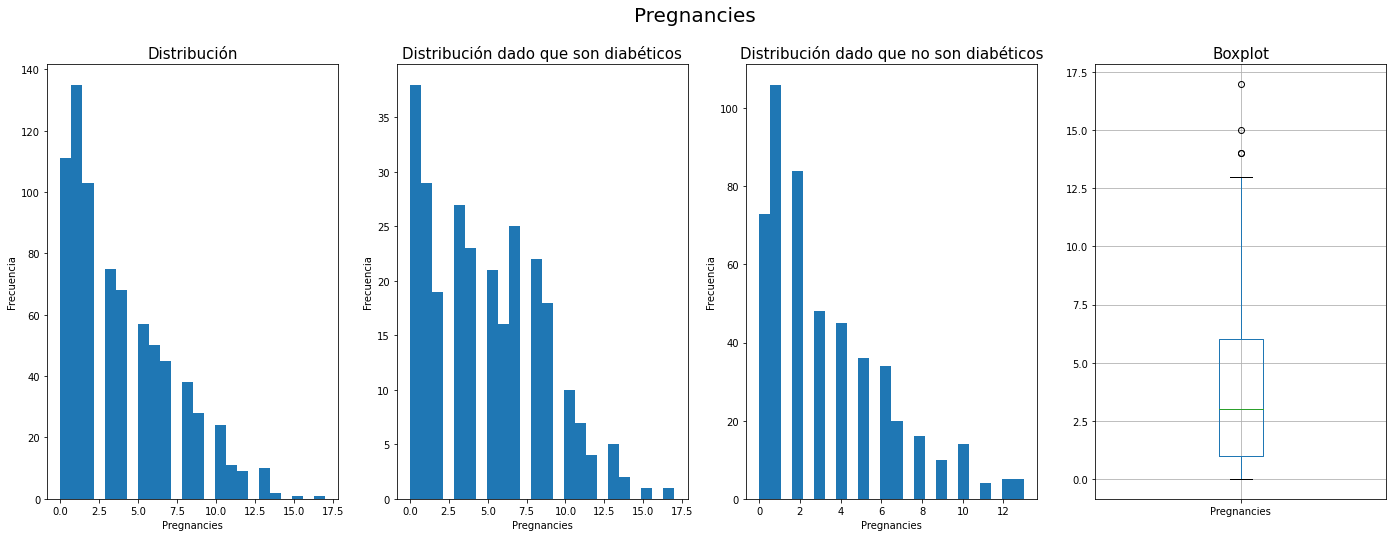

In [8]:
analyze_variable(df, 'Pregnancies')

In [9]:
outliers= get_outliers(df, 'Pregnancies')
print(outliers)

[15, 17, 14, 14]


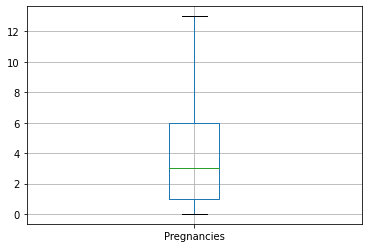

In [10]:
remove_outliers(df, 'Pregnancies')
df.boxplot(column=['Pregnancies']);

### Glucosa

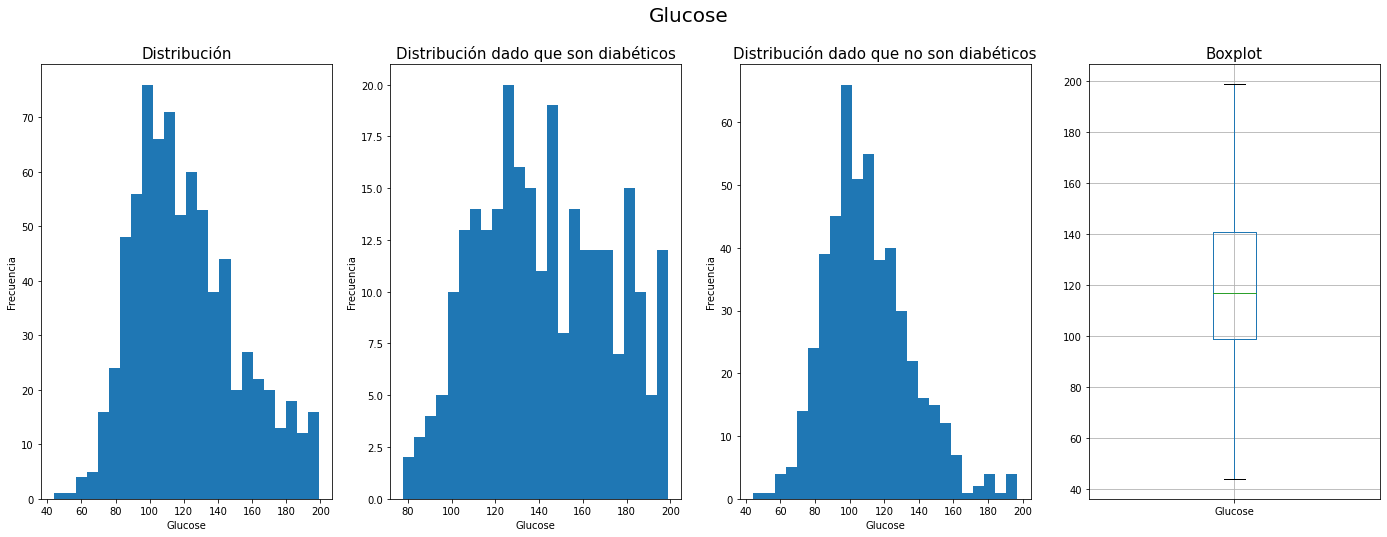

In [11]:
analyze_variable(df, 'Glucose')

In [12]:
outliers= get_outliers(df, 'Glucose')
print(outliers)

[]


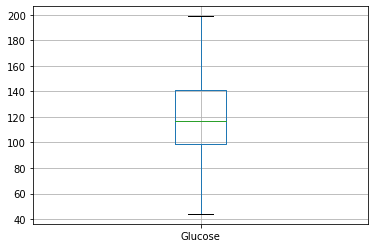

In [13]:
remove_outliers(df, 'Glucose')
df.boxplot(column=['Glucose']);

### Presión Arterial

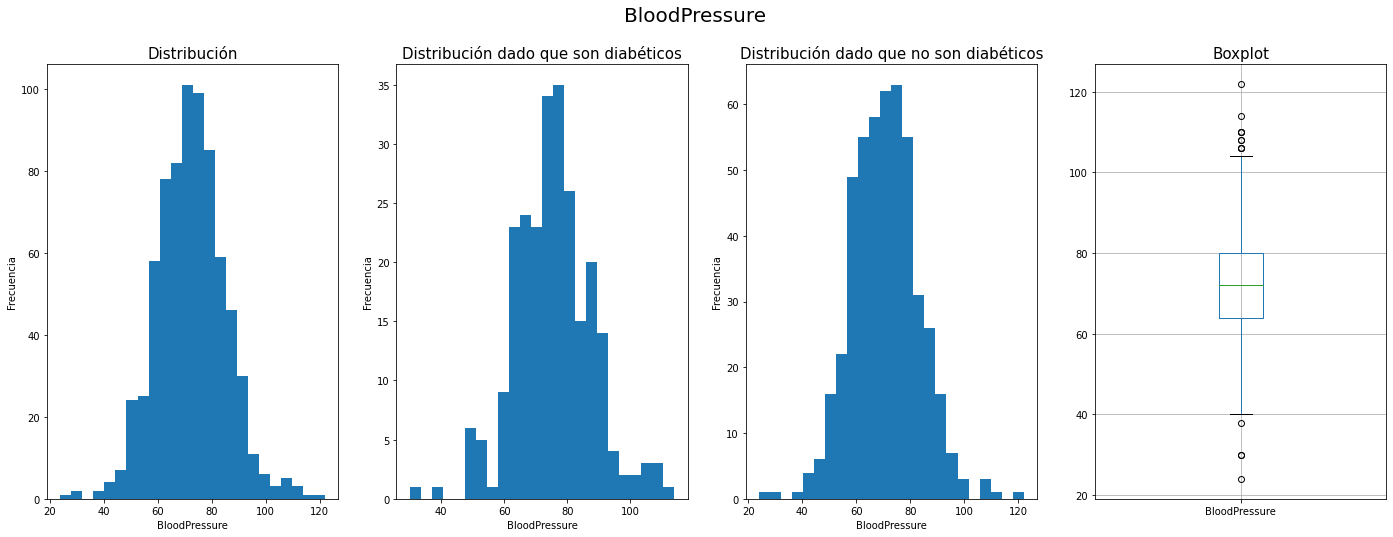

In [14]:
analyze_variable(df, 'BloodPressure')

In [15]:
outliers= get_outliers(df, 'BloodPressure')
print(outliers)

[30.0, 110.0, 108.0, 122.0, 30.0, 110.0, 108.0, 110.0, 24.0, 38.0, 106.0, 106.0, 106.0, 114.0]


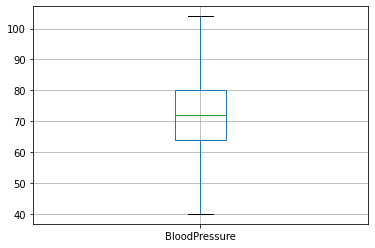

In [16]:
remove_outliers(df, 'BloodPressure')
df.boxplot(column=['BloodPressure']);

### Grosor de la piel del pliegue del tríceps

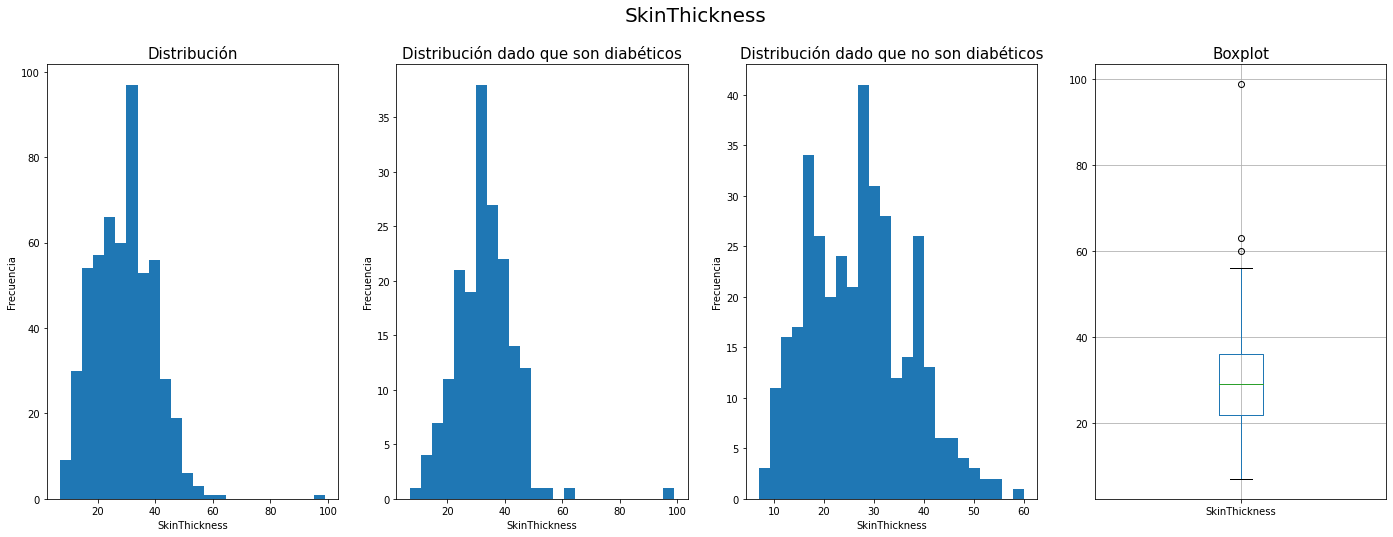

In [17]:
analyze_variable(df, 'SkinThickness')

In [18]:
outliers= get_outliers(df, 'SkinThickness')
print(outliers)

[60.0, 63.0, 99.0]


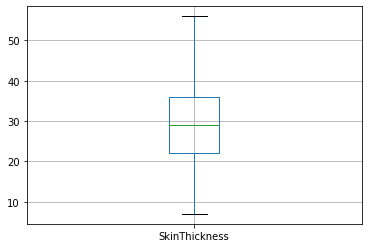

In [19]:
remove_outliers(df, 'SkinThickness')
df.boxplot(column=['SkinThickness']);

### Insulina

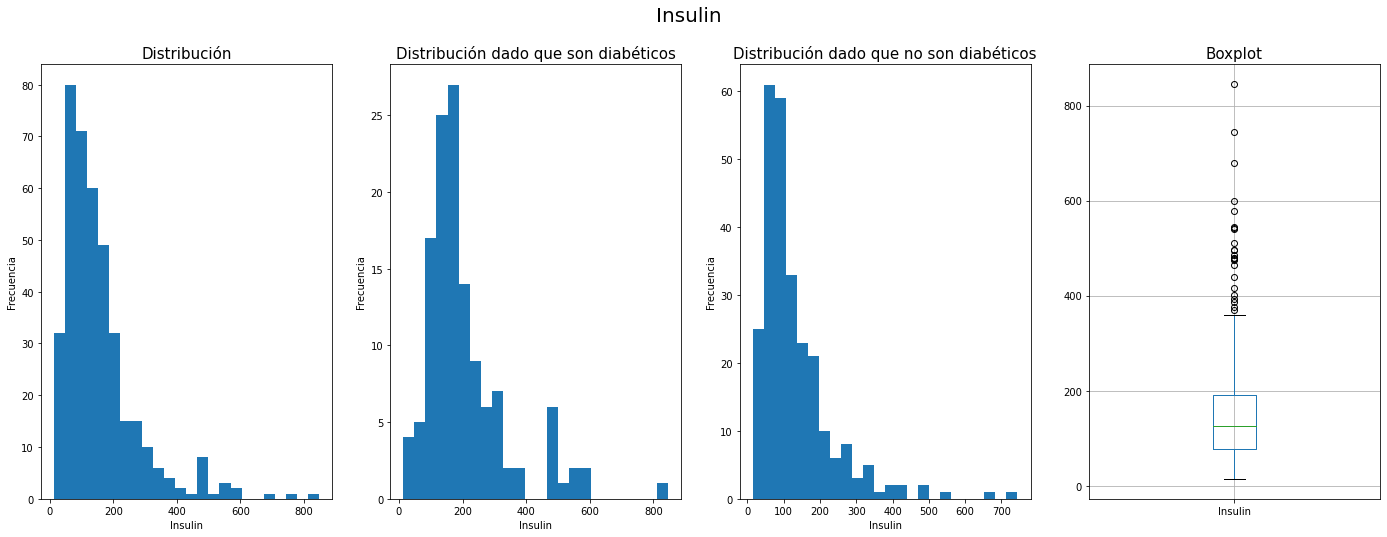

In [20]:
analyze_variable(df, 'Insulin')

In [21]:
outliers= get_outliers(df, 'Insulin')
print(outliers)

[543.0, 846.0, 495.0, 485.0, 495.0, 478.0, 744.0, 370.0, 680.0, 402.0, 375.0, 545.0, 465.0, 415.0, 579.0, 474.0, 480.0, 600.0, 440.0, 540.0, 480.0, 387.0, 392.0, 510.0]


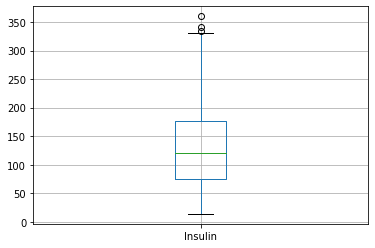

In [22]:
remove_outliers(df, 'Insulin')
df.boxplot(column=['Insulin']);

### Índice de Masa Corporal

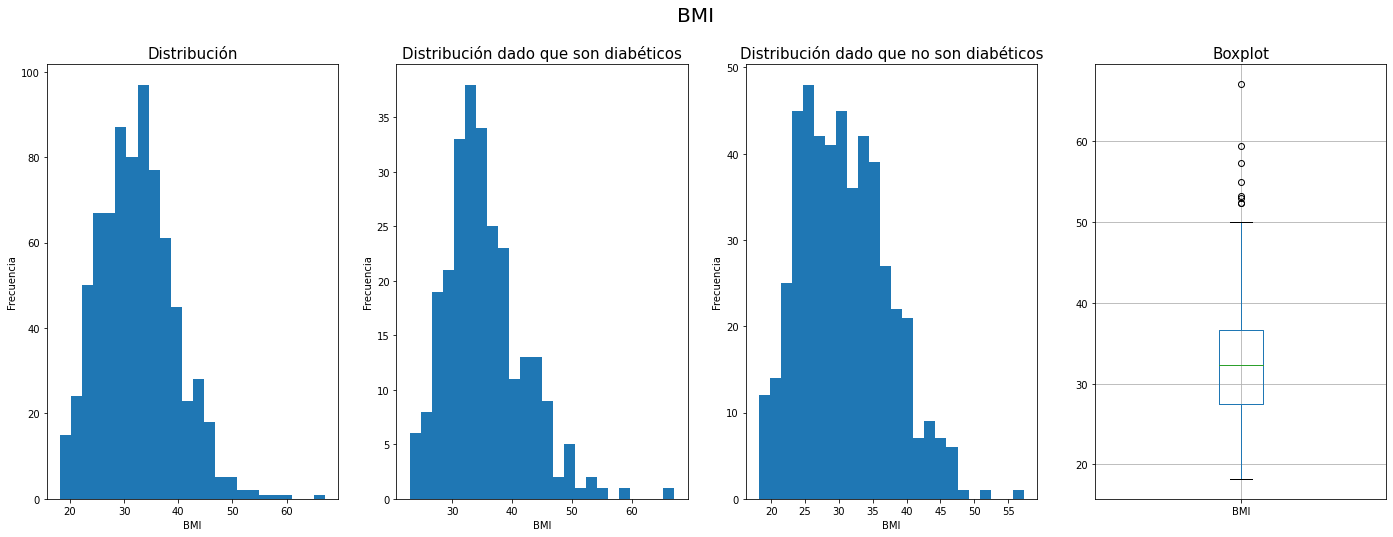

In [23]:
analyze_variable(df, 'BMI')

In [24]:
outliers= get_outliers(df, 'BMI')
print(outliers)

[53.2, 55.0, 67.1, 52.3, 52.3, 52.9, 59.4, 57.3]


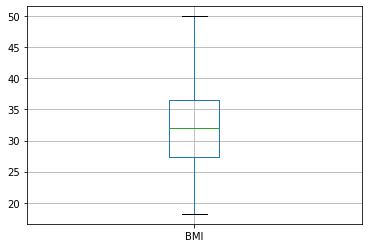

In [25]:
remove_outliers(df, 'BMI')
df.boxplot(column=['BMI']);

### Diabetes Pedigree Function

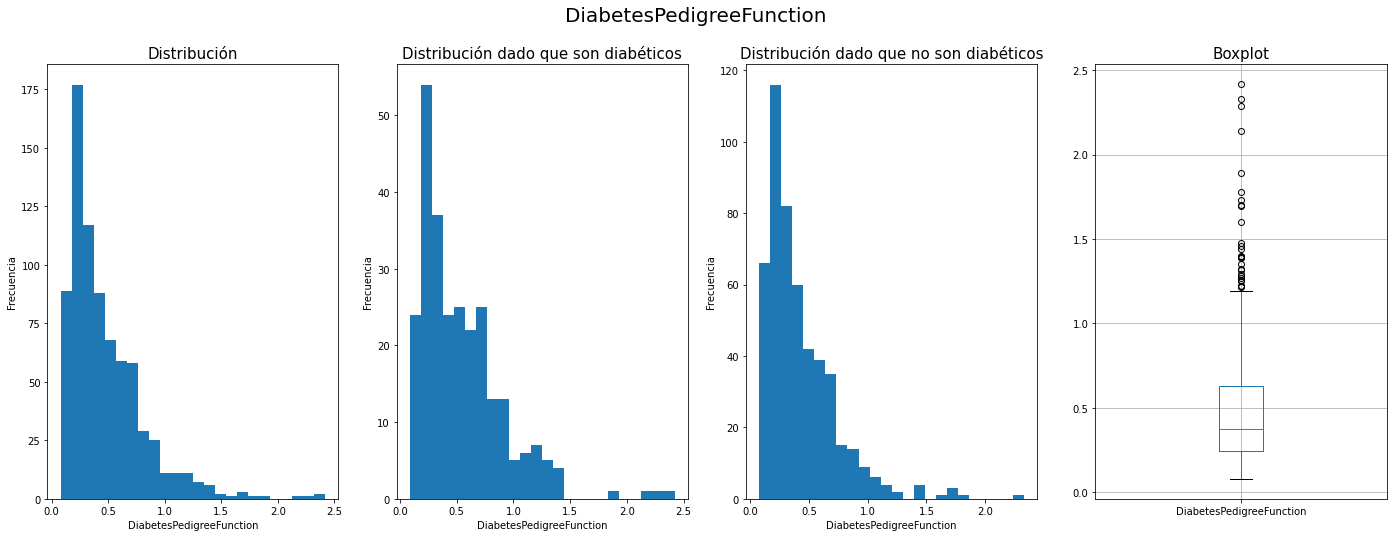

In [26]:
analyze_variable(df, 'DiabetesPedigreeFunction')

In [27]:
outliers= get_outliers(df, 'DiabetesPedigreeFunction')
print(outliers)

[2.288, 1.441, 1.39, 1.893, 1.781, 1.222, 1.4, 1.321, 1.224, 2.329, 1.318, 1.213, 1.353, 1.224, 1.391, 1.476, 2.137, 1.731, 1.268, 1.6, 2.42, 1.251, 1.699, 1.258, 1.282, 1.698, 1.461, 1.292, 1.394]


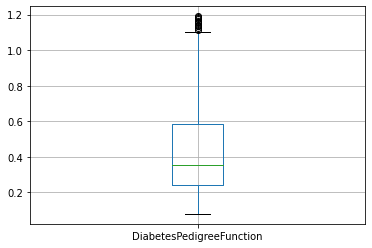

In [28]:
remove_outliers(df, 'DiabetesPedigreeFunction')
df.boxplot(column=['DiabetesPedigreeFunction']);

### Edad

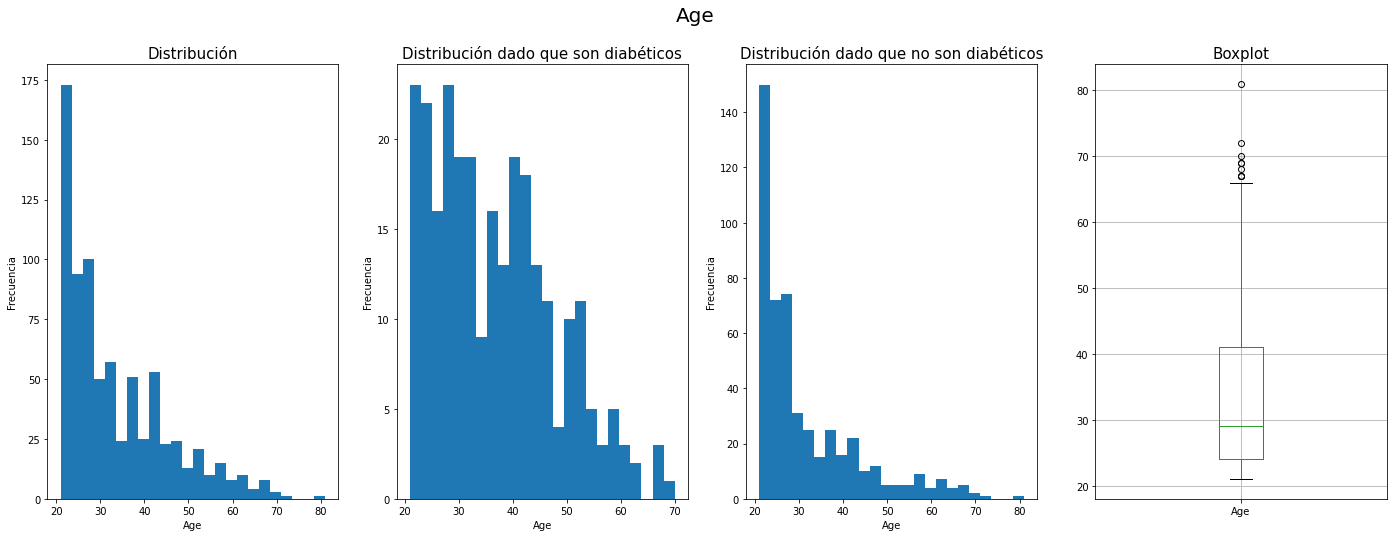

In [29]:
analyze_variable(df, 'Age')

In [30]:
outliers= get_outliers(df, 'Age')
print(outliers)

[69, 67, 72, 81, 67, 67, 70, 68, 69]


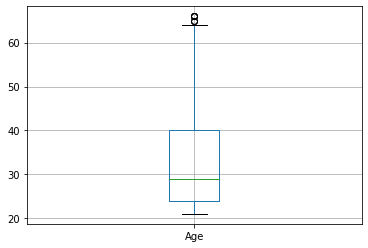

In [31]:
remove_outliers(df, 'Age')
df.boxplot(column=['Age']);

### Matriz de correlación
Se genera la matriz de correlación de el dataset filtrado. De esta forma, se busca identificar aquellas variables que tengan un alto grado de vinculación. En este caso, se podría prescindir de una de ellas para realizar la clasificación dado que las dos "aportan la misma información" al problema.

In [32]:
import seaborn as sb
import matplotlib.pyplot as plt

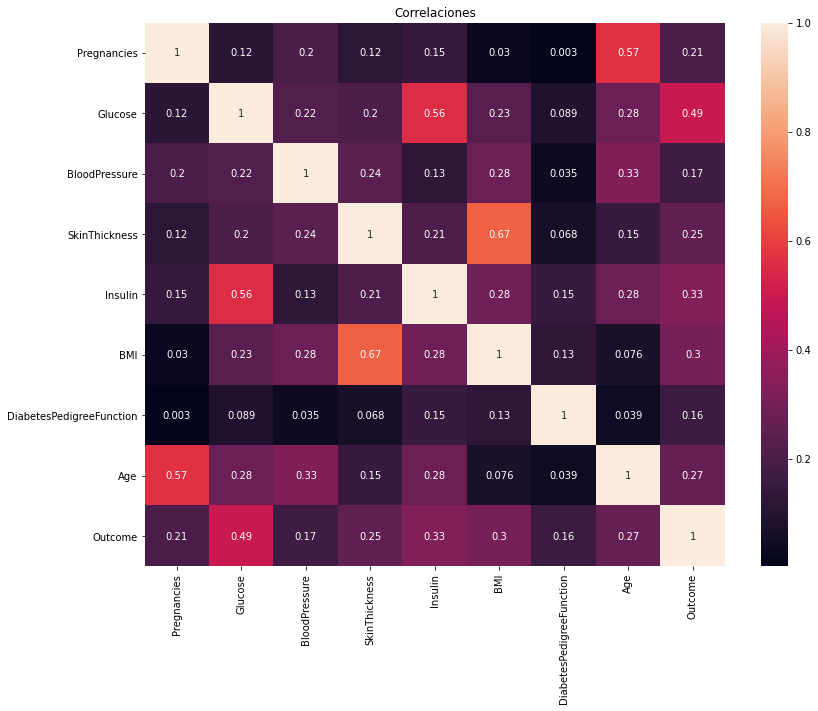

In [33]:
# Correlation matrix
corr_matrix = df.corr()
fig, ax = plt.subplots(1, 1, figsize=(13, 10))
sb.heatmap(corr_matrix, annot=True, ax=ax);
ax.set_title('Correlaciones')
plt.show()

En la matriz anterior, se observa un alto grado de correlación entre las variables SkinThickness-BMI, Insulin-Glucose y Pregnancies-Age. En principio, esto indicaría que se podría emplear solo una de cada par.